# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [32]:
# Add your imports here
from datetime import datetime
import seaborn as sns
import re
import pandas as pd
import numpy as np
import scipy as sp
import findspark
findspark.init(r"C:\Users\Lucas\Desktop\ADA\spark-2.3.2-bin-hadoop2.7")
from pyspark.sql import *
%matplotlib inline

from pyspark.sql.functions import *
from pyspark.sql.functions import min


import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()
data_folder = 'Data/'

from pyspark import SparkContext
sc = spark.sparkContext

from pyspark.sql.functions import substring
from pyspark.sql.functions import to_timestamp
from pyspark.sql import Row
from pyspark.sql.types import DoubleType

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import pyspark.sql.functions as f
from pyspark.sql.functions import explode

Populating the interactive namespace from numpy and matplotlib


C:\Users\Lucas\Anaconda3\envs\ada\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sinh', 'cbrt', 'broadcast', 'log2', 'randn', 'sin', 'cosh', 'split', 'log10', 'rank', 'log1p', 'isnan', 'tan', 'tanh', 'f', 'size', 'log', 'mean', 'hypot', 'sqrt', 'floor', 'expm1', 'array', 'radians', 'rint', 'sum', 'datetime', 'repeat', 'rand', 'degrees', 'trunc', 'cos', 'ceil', 'exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [2]:
#load the dataset
posts_rdd = spark.read.json(data_folder + "Posts.json")

In [10]:
#create rdd containing only the questions and find the number of questions
questions_rdd=posts_rdd.filter(posts_rdd.PostTypeId == 1)
questions_rdd.count()


15647060

In [4]:
#Same operation for answers
answers_rdd=posts_rdd.filter(posts_rdd.PostTypeId == 2)
answers_rdd.count()

25192772

In [ ]:
#tags_rdd=questions_rdd.rdd.map(lambda line: line.strip().split(',')[4],1)
#movies_count=tags_rdd.reduceByKey(lambda count_i,count_ii: count_i+count_ii)
#questions_rdd_null_score=questions_rdd.filter(lambda r : r[3] == '0')
#questions_rdd_null_score.count()

In [ ]:
#to save memory and time we can save and load our dataset under the parquet format
posts_rdd.write.mode('ignore').parquet("posts.parquet")
posts_parquet = spark.read.parquet("posts.parquet")


In [11]:
#df=questions_rdd.cube("Tags").count()
#ndf=df[df['count']<100]
#ndf.show()/df
#or :
#questions_pyspark_rdd=questions_pyspark_rdd.withColumn("Tags", substring(col("CreationDate"), 0, 4))

#First we clean the <> sign from Tags column and separate different tags by space
questions_rdd=questions_rdd.withColumn("Tags",regexp_replace("Tags","><"," ")) 
questions_rdd=questions_rdd.withColumn("Tags",regexp_replace("Tags","<",""))
questions_rdd=questions_rdd.withColumn("Tags",regexp_replace("Tags",">",""))

#we transform the Tags column in an array of string containing the different Tags
questions_rdd=questions_rdd.withColumn("Tags",f.split(questions_rdd["Tags"],' '))

#Then we duplicate row when several tags are detected in order to count them correctly and individually
tags_occurence=questions_rdd.withColumn("Tags", explode(questions_rdd.Tags)).groupBy("Tags").count()


In [14]:
tags_occurence.show()

+----------------+-----+
|            Tags|count|
+----------------+-----+
|  response.write|  137|
|          iframe|26125|
|           input|22045|
|       arguments| 7157|
|       core-text|  689|
|             dts|  308|
|       standards| 2495|
|     parentheses|  672|
|         cgimage|  474|
|         sd-card| 1239|
|      setuptools| 1809|
| instruction-set|  303|
|database-restore|  553|
|      data-aware|   22|
|    fuzzy-search|  600|
|    transmitfile|   30|
|          telnet| 1969|
|        brackets|  659|
|android-manifest| 4488|
|         jbutton| 4015|
+----------------+-----+
only showing top 20 rows



**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [25]:
#We calculate the proportion of tags that appear in fewer than 100 question
less_pop_tags=tags_occurence[tags_occurence['count']<100]

#We calculate the proportion
less_pop_tags.count()/tags_occurence.count()

0.6797939389364833

TypeError: 'Column' object is not callable

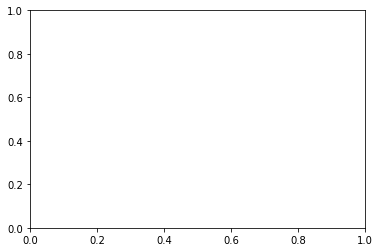

In [26]:
sns.distplot(tags_occurence['count'])

In [15]:
#We sort the 10 most popular tags 
most_pop_tags=tags_occurence.sort('count',ascending=False).take(10)

In [27]:
#We create a dataframe in order to be able to convert it
most_pop_tags_df=spark.createDataFrame(most_pop_tags)

In [28]:
#conversion
most_pop_tags_pd=most_pop_tags_df.toPandas()


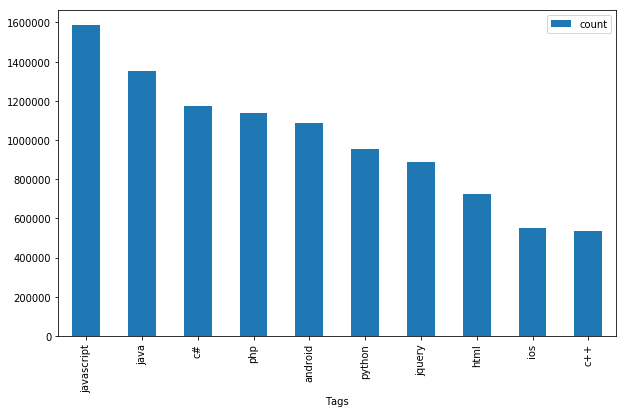

In [34]:
#bar chart with the number of question for the 10 most popular tags
most_pop_tags_pd.index=most_pop_tags_pd['Tags']
most_pop_tags_pd.plot.bar()


In [119]:
questions_rdd.take(1)

[Row(CreationDate='2010-10-26T03:17:55.603+02:00', Id=4020437, ParentId=None, PostTypeId=1, Score=0, Tags=['asp.net-mvc', 'jquery-ui'], Title='display jquery dialog till data is loaded', ViewCount=510)]

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

In [35]:
#We firt take the posts corresponding to question
questions_rdd=posts_rdd.filter(posts_rdd.PostTypeId == 1)

#We select any question concerning random effect
questions_random_rdd=questions_rdd.filter("Tags like '%random-effects%'")

#We select score and ViewCount
to_plot_rdd=questions_random_rdd.select('score','ViewCount')

#And convert it to Pandas for representation
plot=to_plot_rdd.toPandas()


C:\Users\Lucas\Anaconda3\envs\ada\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


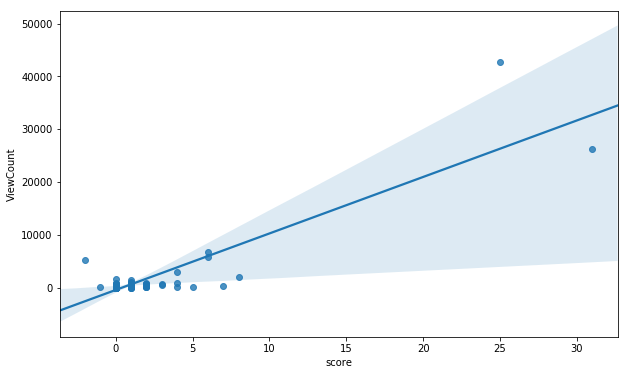

In [36]:
sns.regplot(x=plot['score'],y=plot['ViewCount'])

C:\Users\Lucas\Anaconda3\envs\ada\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


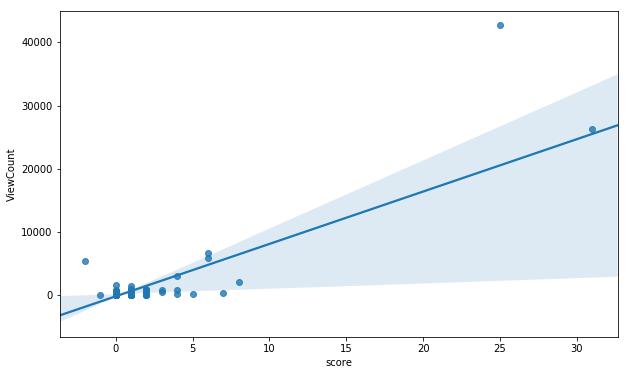

In [37]:
sns.regplot(x=plot['score'],y=plot['ViewCount'],robust=True)

In [38]:
display(plot.corr(method='pearson'))
display(plot[plot['ViewCount']<20000].corr(method='pearson'))

,score,ViewCount
score,1.000000,0.882197
ViewCount,0.882197,1.000000


,score,ViewCount
score,1.000000,0.439389
ViewCount,0.439389,1.000000


C:\Users\Lucas\Anaconda3\envs\ada\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


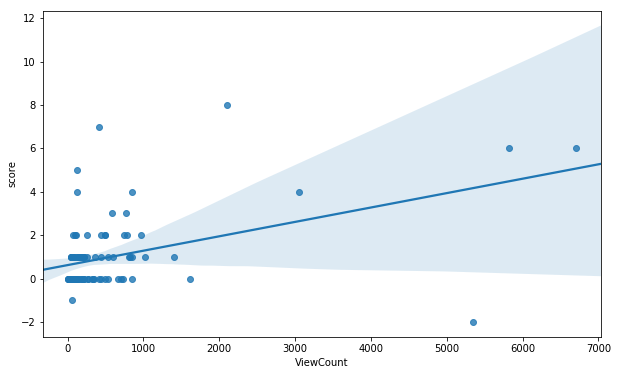

In [39]:
plot=plot[plot['ViewCount']<20000]
sns.regplot(plot['ViewCount'],plot['score'])

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [40]:
questions_rdd=posts_rdd.filter(posts_rdd.PostTypeId == 1)
questions_pyspark_rdd=questions_rdd.filter("Tags like '%<pyspark>%'")

In [41]:
questions_pyspark_rdd=questions_pyspark_rdd.withColumn("CreationDate",regexp_replace("CreationDate","-",""))
questions_pyspark_rdd=questions_pyspark_rdd.withColumn("Year", substring(col("CreationDate"), 0, 4))
questions_pyspark_rdd=questions_pyspark_rdd.withColumn("Month", substring(col("CreationDate"), 5, 2))
questions_pyspark_rdd=questions_pyspark_rdd.withColumn("Day", substring(col("CreationDate"), 7, 2))

In [42]:
questions_pyspark_rdd.take(1)

[Row(CreationDate='20150218T22:18:59.567+01:00', Id=28595048, ParentId=None, PostTypeId=1, Score=1, Tags='<python><tuples><flatten><pyspark>', Title='Flatten a tuple of unknown length', ViewCount=431, Year='2015', Month='02', Day='18')]

In [43]:
to_plot=questions_pyspark_rdd.groupBy("Month","Year").count()


In [44]:
to_plot = to_plot.withColumn('Time', 
                    concat(col('Year'),lit('.'), col('Month')))

to_plot=to_plot.withColumn("Time",to_plot["Time"].cast(DoubleType()))

In [45]:
to_plot=to_plot.select('Time','count')

In [46]:
to_plot=to_plot.toPandas()


In [47]:
to_plot_f=to_plot.apply(pd.to_numeric)


In [48]:
to_plot_f=to_plot_f.sort_values(by='Time')

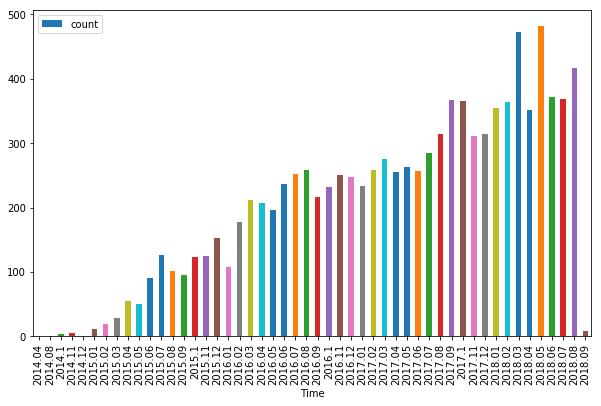

In [49]:
to_plot_f.plot.bar(x='Time',y='count')
